In [1]:
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from dataload import lang, localdata
# from tagger.charbilstm import CharBiLSTM

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
tag_PAD = lang.tag_PAD
tag_UNK = lang.tag_UNK

datasets, engdict, posdict = localdata.load_eng_pos(device, strmode=True) # , charmode=True)
num_words = engdict.n_words
num_chars = engdict.n_chars
num_poss = posdict.n_words
print(num_words)
print(num_chars)
print(num_poss)
# print(MAX_LENGTH)
print(engdict.max_len_char)
print(engdict.max_len_word)
print(posdict.max_len_char)
print(posdict.max_len_word)

print(len(datasets['dev'].y_data))
print(len(datasets['test'].y_data))
print(len(datasets['train'].y_data))

21591
82
46
54
78
4
78
936
2012
8000


In [5]:
# engdict.index2char

In [6]:
# def word2chars(word):
#     for i in word:
#         engdict.index2word[i]
#     seqword
#     return [c for c]
# def word2chars(seqwordidx):
#     for i in seqwordidx:
#         engdict.index2word[i]
#     seqword
#     return seqchars

In [7]:
def iteration(samples, optimizer, criterion):
    x_train, y_train = samples
        
    optimizer.zero_grad()

    o = model(x_train)
    o = o.view(-1,o.size(-1))
    t = y_train.view(-1)

    loss = criterion(o, t)
    loss.backward()
    optimizer.step()

    return loss.item()

In [8]:
def epoch(model, optimizer, criterion, dataloader):
    model.train()
    list_loss = []
    for batch_idx, samples in enumerate(dataloader):
        loss = iteration(samples, optimizer, criterion)
        list_loss.append(loss)
    return list_loss

In [9]:
def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples

        o = model(x_train)
        o = o.view(-1,o.size(-1))
        t = y_train.view(-1)

        total_loss += criterion(o, t).item()

        # if batch_idx % 100 == 0:
            # print(batch_idx, loss.item())
            
    # print(batch_idx, loss.item())
    return total_loss / (batch_idx+1)

In [10]:
def scores(model, dataset, batch_size):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    total_samples = len(dataset)
    cnt_corr_samples = 0
    total_words = 0
    cnt_corr_words = 0
    c = posdict.n_words
    table = torch.zeros(c,c)
    
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples
        
        o = model(x_train)
        t = y_train.view(-1)

        __tagged, tagged = torch.max(o, dim=-1)
        
        for i in range(y_train.size(0)):
            l = y_train[i].tolist()
            if tag_PAD in l:
                seq_len = l.index(tag_PAD)
            else:
                seq_len = len(l)
            
            _y = y_train[i,:seq_len]
            _p = tagged[i,:seq_len]
            d = _p!=_y
            cnt_wrong = _p[d].size()[0]
            
            # score1_acc_sample
            if cnt_wrong == 0:
                cnt_corr_samples +=1
                
            # score2_acc_word
            total_words += seq_len
            cnt_corr_words += seq_len - cnt_wrong
            
            # score3_f1
            for j in range(seq_len):
                table[_y[j],_p[j]] += 1

    tp = torch.tensor([table[i,i] for i in range(c)])[2:]
    d0sum = table[2:,2:].sum(dim=0)
    d1sum = table[2:,2:].sum(dim=1)
    allsum = d1sum.sum()
    
    pr = tp / d0sum
    temp = pr != pr
    pr[temp] = 0
    
    re = tp / d1sum
    temp = re != re
    re[temp] = 0
    
    f1 = 2 * pr * re / (pr + re)
    temp = f1 != f1
    f1[temp] = 0
    
    avg_f1 = (f1 * d1sum).sum() / allsum
  
    return (cnt_corr_samples / total_samples,
            cnt_corr_words / total_words,
            avg_f1.item())

In [11]:
def train_losses_scores(model, optimizer, criterion, datasets, batch_size, num_epoch):

    dict_losses={'train': [],
                 'dev': [],
                 'test': []
                }
    
    dict_scores={'train': [[],[],[]],
                 'dev': [[],[],[]],
                 'test': [[],[],[]]
                }
    best_dev_f1 = 0.0
    for epoch_i in range(1,num_epoch+1):
        dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True)
        dataloader_dev = DataLoader(datasets['dev'], batch_size=batch_size, shuffle=True)
        dataloader_test = DataLoader(datasets['test'], batch_size=batch_size, shuffle=True)
        print(f'\r{epoch_i}', end='')
        temp = epoch(model, optimizer, criterion, dataloader)
        dict_losses['train'].extend(temp)
        dict_losses['dev'].append(evaluate(model, criterion, dataloader_dev))
        dict_losses['test'].append(evaluate(model, criterion, dataloader_test))

        s_train = scores(model, datasets['train'], 100)
        s_dev = scores(model, datasets['dev'], 100)
        s_test = scores(model, datasets['test'], 100)
        
        dict_scores['train'][0].append(s_train[0])
        dict_scores['train'][1].append(s_train[1])
        dict_scores['train'][2].append(s_train[2])
        dict_scores['dev'][0].append(s_dev[0])
        dict_scores['dev'][1].append(s_dev[1])
        dict_scores['dev'][2].append(s_dev[2])
        dict_scores['test'][0].append(s_test[0])
        dict_scores['test'][1].append(s_test[1])
        dict_scores['test'][2].append(s_test[2])
        
        if s_dev[2] > best_dev_f1:
            print(f' epoch Dev F1 score: {best_dev_f1:.6} -> {s_dev[2]:.6}')
            best_dev_f1 = s_dev[2]
            torch.save(model, 'best_char_bilstm_pos.pt')
    print()
    return dict_losses, dict_scores

In [12]:
def showParallel(words, tags, targets=None):
    if '<PAD>' in words:
        length = words.index('<PAD>')
    else:
        lengths = [len(words),len(tags)]        
        if targets is not None:
            lengths.append(len(targets))
        length = min(lengths)
    
    if targets is not None:
        print(f'{"words":20}{"tags":8}targets')
        for i in range(length):
            color = 31 if tags[i] != targets[i] else 0
            print(f'\033[{color}m{words[i]:20}{tags[i]:8}{targets[i]}\033[0m')
    else:
        print(f'{"words":20}tags')
        for i in range(length):
            print(f'{words[i]:20}{tags[i]}')

In [13]:
def pos_tagging(model, input_seq):
    model.eval()
    o = model(input_seq)
    __tagged, tagged = torch.max(o, dim=-1)
    return tagged

In [14]:
def showGraph(dict_losses, dict_scores):
    plt.figure(figsize=(13,13))

    plt.subplot(421)
    plt.title('Loss')
    plt.plot(range(len(dict_losses['train'])), dict_losses['train'], label='train')
    plt.xlabel('Iteration')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.subplot(423)
    plt.plot(range(1,num_epoch+1), dict_losses['dev'], label='dev')
    plt.plot(range(1,num_epoch+1), dict_losses['test'], label='test')
    plt.xlabel('Epoch')
    plt.ylabel('Dev, Test Loss')
    plt.legend()

    plt.subplot(222)
    plt.plot(range(1,num_epoch+1), dict_scores['train'][0], label='train')
    plt.plot(range(1,num_epoch+1), dict_scores['dev'][0], label='dev')
    plt.plot(range(1,num_epoch+1), dict_scores['test'][0], label='test')
    plt.legend()
    plt.title('score1_acc_sample')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(223)
    plt.plot(range(1,num_epoch+1), dict_scores['train'][1], label='train')
    plt.plot(range(1,num_epoch+1), dict_scores['dev'][1], label='dev')
    plt.plot(range(1,num_epoch+1), dict_scores['test'][1], label='test')
    plt.legend()
    plt.title('score2_acc_word')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(224)
    plt.plot(range(1,num_epoch+1), dict_scores['train'][2], label='train')
    plt.plot(range(1,num_epoch+1), dict_scores['dev'][2], label='dev')
    plt.plot(range(1,num_epoch+1), dict_scores['test'][2], label='test')
    plt.legend()
    plt.title('score3_f1')
    plt.xlabel('Epoch')
    plt.ylabel('Avg F1 Score')

    plt.show()

In [15]:
def calc(model, input_seq, target_seq=None):
    # input_seq = engdict.tensorFromSentence(input_seq, device)
    # input_list = engdict.sentenceFromIndexes(input_seq.tolist())
    input_list = input_seq.split()

    # print(input_list)
    # print(sentenceFromIndexes(posdict, target_seq.tolist()))
    output_list = posdict.sentenceFromIndexes(pos_tagging(model, [input_seq]).view(-1).tolist())
    
    target_list = None
    if target_seq is not None:
        target_list = posdict.sentenceFromIndexes(target_seq.tolist())

#     print(output_list)
    showParallel(input_list, output_list, target_list)

In [16]:
class CharBiLSTM(nn.Module):
    def __init__(self, num_chars, num_words, char_dim, word_dim, size_hidden, num_poss, num_layers, padding_idx):
        super(CharBiLSTM, self).__init__()

        self.char_embedding = nn.Embedding(num_chars, char_dim, padding_idx=padding_idx)
        # self.word_embedding = nn.Embedding(num_words, word_dim, padding_idx=padding_idx)
        
        self.charlstm = nn.LSTM(char_dim, size_hidden, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        
#         self.lstm = nn.LSTM(word_dim+size_hidden*2, size_hidden, num_layers=num_layers,
#                             batch_first=True, bidirectional=True)
        self.lstm = nn.LSTM(size_hidden*2, size_hidden, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        
        self.dropout = nn.Dropout(0.25)
        
        self.linear = nn.Linear(size_hidden*2, num_poss)

#     def forward(self, input_seqword, input_seqword_seqchar):
    def forward(self, input_seqword):
        # print(input_seqword.size())
        # print(input_seqword)
        # batch-seq(1 int)
        bat = []
        for s in input_seqword:
            bat.append(engdict.charTensorFromSentence(s, device=device))
        input_seqword_seqchar = torch.stack(bat)
        # print(input_seqword_seqchar.size())
        # batch-seq-chars
        
        batch_seqword_seqchar_charemb = self.char_embedding(input_seqword_seqchar)
        # print(batch_seqword_seqchar_charemb.size())
        # batch-seq-cahr-char_dim
        
        _size = batch_seqword_seqchar_charemb.size()
        batchseqword_seqchar_charemb = batch_seqword_seqchar_charemb.view(-1, _size[2], _size[3])
        
        _output_seq, (bi_batchseqword_charforback, c_n) = self.charlstm(batchseqword_seqchar_charemb)
        # print(bi_batchseqword_charforback.size())
        # 2(BiDirection)-batch*seq-size_hidden
        batchseqword_charforback = torch.cat((bi_batchseqword_charforback[0],bi_batchseqword_charforback[1]), dim=1)
        # print(batchseqword_charforback.size())
        # batch*seq-size_hidden*2(BiDirection)
        batch_seqword_charforback = batchseqword_charforback.view(_size[0], _size[1], -1)
        # print(batch_seqword_charforback.size())
        # batch-seq-size_hidden*2(BiDirection)


        # batch_seqword_wordemb = self.word_embedding(input_seqword)
        # print(batch_seqword_wordemb.size())
        # batch-seq-word_dim
        
        # batch_seqword_wordrep = torch.cat((batch_seqword_wordemb, batch_seqword_charforback), dim=2)
        batch_seqword_wordrep = batch_seqword_charforback
        # print(batch_seqword_wordrep.size())
        ## batch-seq-word_dim+size_hidden*2(BiDirection)
        # batch-seq-size_hidden*2(BiDirection)
        
        output_seq, (h_n, c_n) = self.lstm(batch_seqword_wordrep)
        # print(output_seq.size())
        # batch-seq-size_hidden*2(BiDirection)
        # print(h_n.size())
        # 2(BiDirection)-batch-size_hidden

        output = self.linear(self.dropout(output_seq))
        # print(output.size())
        # batch-seq-num_poss

        return output #, output_seq, (h_n, c_n)

In [17]:
# embedding_dim = 100
char_dim = 10
word_dim = 50
size_hidden = 50
num_layers = 1
size_out = num_poss
size_batch = 100
# criterion  = nn.CrossEntropyLoss().to(device)
criterion  = nn.CrossEntropyLoss(ignore_index=tag_PAD).to(device)

In [18]:
model = CharBiLSTM(num_chars, num_words, char_dim, word_dim, size_hidden, size_out, num_layers, tag_PAD).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epoch = 60
st = time.time()
dict_losses, dict_scores = train_losses_scores(model, optimizer, criterion, datasets, size_batch, num_epoch)
print(f'\t{time.time()-st:5}')

1 epoch F1 score: 0.0 -> 0.699373
2 epoch F1 score: 0.699373 -> 0.889145
3 epoch F1 score: 0.889145 -> 0.920572
4 epoch F1 score: 0.920572 -> 0.9384
5 epoch F1 score: 0.9384 -> 0.95107
6 epoch F1 score: 0.95107 -> 0.955333
7 epoch F1 score: 0.955333 -> 0.957996
8 epoch F1 score: 0.957996 -> 0.963723
9 epoch F1 score: 0.963723 -> 0.965138
10 epoch F1 score: 0.965138 -> 0.968958
11 epoch F1 score: 0.968958 -> 0.969643
12 epoch F1 score: 0.969643 -> 0.969831
13 epoch F1 score: 0.969831 -> 0.970541
14 epoch F1 score: 0.970541 -> 0.970794
15 epoch F1 score: 0.970794 -> 0.971216
16 epoch F1 score: 0.971216 -> 0.97237
20 epoch F1 score: 0.97237 -> 0.973237
25 epoch F1 score: 0.973237 -> 0.973418
26 epoch F1 score: 0.973418 -> 0.974787
35 epoch F1 score: 0.974787 -> 0.974846
36 epoch F1 score: 0.974846 -> 0.975508
44 epoch F1 score: 0.975508 -> 0.975758
45 epoch F1 score: 0.975758 -> 0.97577
60
	4034.533582687378


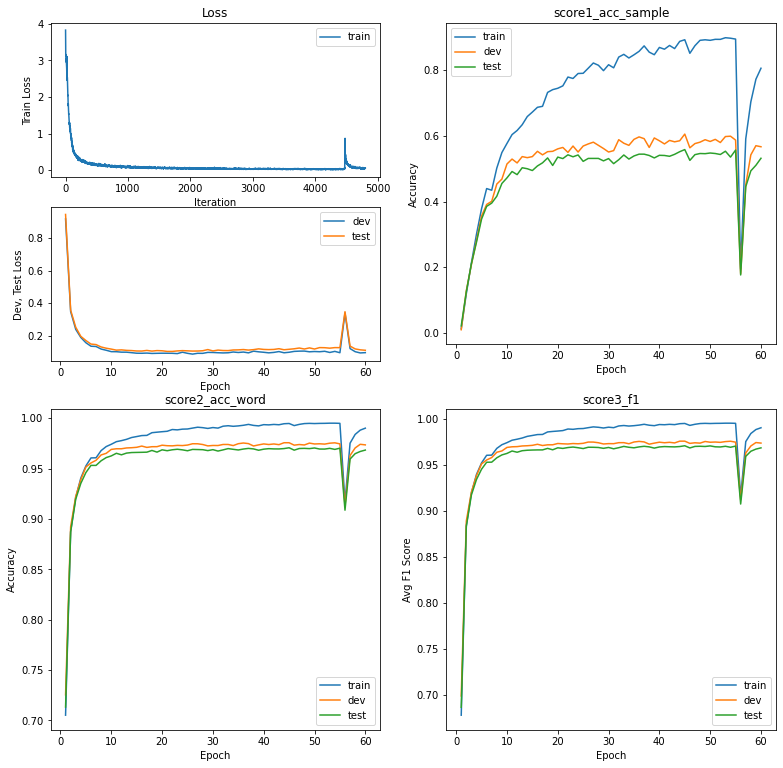

In [19]:
showGraph(dict_losses, dict_scores)

In [20]:
score_type=2
for i in range(len(dict_scores["train"][score_type])):
    print(f'{dict_scores["train"][score_type][i]:<.5}   {dict_scores["dev"][score_type][i]:<05.4}   {dict_scores["test"][score_type][i]:.5}')

0.67851   0.6994   0.68706
0.88395   0.8891   0.8833
0.91962   0.9206   0.91739
0.93964   0.9384   0.93419
0.95216   0.9511   0.94535
0.96044   0.9553   0.95289
0.96061   0.958   0.95297
0.96793   0.9637   0.95772
0.97189   0.9651   0.96083
0.97414   0.969   0.96246
0.97677   0.9696   0.96507
0.97788   0.9698   0.96375
0.97918   0.9705   0.96539
0.98096   0.9708   0.9659
0.98192   0.9712   0.96612
0.98291   0.9724   0.96626
0.98303   0.971   0.96627
0.98576   0.9718   0.96792
0.98629   0.9718   0.96639
0.98673   0.9732   0.96855
0.98723   0.9729   0.96788
0.98893   0.9727   0.96883
0.98861   0.9732   0.96937
0.9893   0.9729   0.96864
0.98946   0.9734   0.96772
0.99038   0.9748   0.96916
0.99125   0.9748   0.96911
0.99081   0.974   0.9689
0.99003   0.9727   0.96797
0.99091   0.9731   0.96893
0.99037   0.973   0.96747
0.99225   0.9741   0.96867
0.99273   0.9741   0.97008
0.99214   0.9729   0.96912
0.99255   0.9748   0.96855
0.99317   0.9755   0.96953
0.99406   0.9749   0.97018
0.99304   

In [29]:
testset = datasets['test']
for ii in range(len(testset)):
    i = 300
    input_seq = testset.x_data[i]
    target_seq = testset.y_data[i]
    calc(model, input_seq, target_seq)
    break
#     print(target_seq)

words               tags    targets
Public              JJ      JJ
protests            NNS     NNS
against             IN      IN
him                 PRP     PRP
were                VBD     VBD
triggered           VBN     VBN
in                  IN      IN
June                NNP     NNP
1987                CD      CD
due                 JJ      JJ
to                  TO      TO
charges             NNS     NNS
by                  IN      IN
Diaz                NNP     NNP
Herrera             NNP     NNP
,                   ,       ,
his                 PRP$    PRP$
former              JJ      JJ
chief               NN      NN
of                  IN      IN
staff               NN      NN
,                   ,       ,
that                IN      IN
Mr.                 NNP     NNP
Noriega             NNP     NNP
had                 VBD     VBD
stolen              VBN     VBN
the                 DT      DT
1984                CD      CD
election            NN      NN
and                 CC

In [22]:
sen = 'I am your father .'
in_sen = torch.tensor(engdict.indexesFromSentence(sen), device=device)

sen2 = [4609,   25,   35,  116, 4610, 1562,   74,  115, 4611,   49, 4612, 1456,
        4613,  224,  691,    6, 4614,   76,   30, 1742, 4615,  308,  107, 4614,
         116, 4616, 4617,   17]
in_sen = torch.tensor(sen2, device=device)

calc(model, sen)

words               tags
I                   PRP
am                  VBP
your                PRP$
father              NN
.                   .
